In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
print(tf.__version__)

2.13.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/chest_xray.zip"

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: chest_xray/train/PNEUMONIA/person413_bacteria_1829.jpeg  
  inflating: __MACOSX/chest_xray/train/PNEUMONIA/._person413_bacteria_1829.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1502_virus_2612.jpeg  
  inflating: __MACOSX/chest_xray/train/PNEUMONIA/._person1502_virus_2612.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1400_bacteria_3554.jpeg  
  inflating: __MACOSX/chest_xray/train/PNEUMONIA/._person1400_bacteria_3554.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person383_bacteria_1754.jpeg  
  inflating: __MACOSX/chest_xray/train/PNEUMONIA/._person383_bacteria_1754.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person605_virus_1166.jpeg  
  inflating: __MACOSX/chest_xray/train/PNEUMONIA/._person605_virus_1166.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person690_bacteria_2587.jpeg  
  inflating: __MACOSX/chest_xray/train/PNEUMONIA/._person690_bacteria_2587.jpeg  
  inflating: chest_xray/t

In [ ]:
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"
val_dir = "/content/chest_xray/val"

image_size = (192, 192)
batch_size = 64

Since we have only two classes we can use binary classification (0 or 1).

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
    )

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
    )
val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


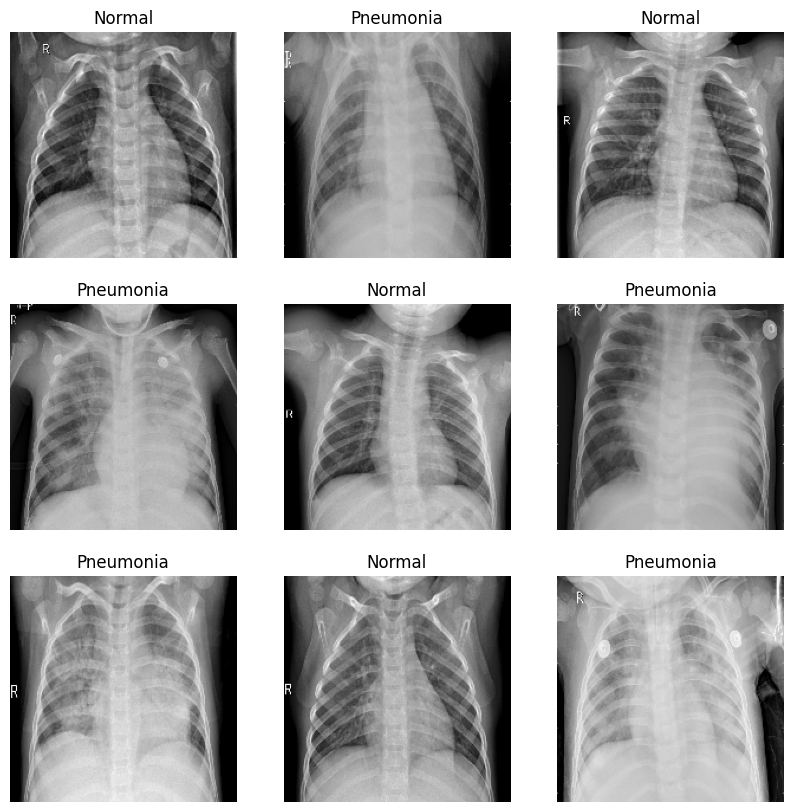

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title( "Pneumonia" if labels[i].numpy().astype("uint8") == 1 else "Normal")
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in test_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in val_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 192, 192, 3)
(64, 1)
(64, 192, 192, 3)
(64, 1)
(16, 192, 192, 3)
(16, 1)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (192, 192, 3), include_top=False, weights = "imagenet")

In [ ]:
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape = (192, 192, 3))
x = preprocess_input(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 192, 192, 3)]     0         
                                                                 
 tf.math.truediv_10 (TFOpLa  (None, 192, 192, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_10 (TFOpL  (None, 192, 192, 3)       0         
 ambda)                                                          
                                                                 
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 0 (GlobalAveragePooling2D)                                

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)



In [ ]:
base_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold = 0, name = "accuracy")])

In [ ]:
history = model.fit(train_data, epochs = 10, validation_data = val_data, callbacks=[early_stopping])

Epoch 1/10
82/82 [==============================] - 40s 401ms/step - loss: 0.7558 - accuracy: 0.6171 - val_loss: 1.0726 - val_accuracy: 0.4375
Epoch 2/10
82/82 [==============================] - 38s 393ms/step - loss: 0.5638 - accuracy: 0.7272 - val_loss: 0.9123 - val_accuracy: 0.4375
Epoch 3/10
82/82 [==============================] - 34s 370ms/step - loss: 0.4471 - accuracy: 0.7891 - val_loss: 0.8252 - val_accuracy: 0.5000
Epoch 4/10
82/82 [==============================] - 36s 387ms/step - loss: 0.3673 - accuracy: 0.8426 - val_loss: 0.7685 - val_accuracy: 0.5000
Epoch 5/10
82/82 [==============================] - 33s 372ms/step - loss: 0.3235 - accuracy: 0.8685 - val_loss: 0.7179 - val_accuracy: 0.5625
Epoch 6/10
82/82 [==============================] - 35s 370ms/step - loss: 0.2826 - accuracy: 0.8882 - val_loss: 0.6857 - val_accuracy: 0.6250
Epoch 7/10
82/82 [==============================] - 35s 375ms/step - loss: 0.2617 - accuracy: 0.9005 - val_loss: 0.6492 - val_accuracy: 0.6875

In [ ]:
results = model.evaluate(test_data)

10/10 [==============================] - 3s 86ms/step - loss: 0.4281 - accuracy: 0.7756


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name="accuracy")])

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 192, 192, 3)]     0         
                                                                 
 tf.math.truediv_10 (TFOpLa  (None, 192, 192, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_10 (TFOpL  (None, 192, 192, 3)       0         
 ambda)                                                          
                                                                 
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 0 (GlobalAveragePooling2D)                                

In [ ]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data, callbacks=[early_stopping])

Epoch 10/20
82/82 [==============================] - 50s 383ms/step - loss: 0.1365 - accuracy: 0.9479 - val_loss: 0.5866 - val_accuracy: 0.7500
Epoch 11/20
82/82 [==============================] - 35s 374ms/step - loss: 0.0935 - accuracy: 0.9618 - val_loss: 0.3929 - val_accuracy: 0.8125
Epoch 12/20
82/82 [==============================] - 34s 378ms/step - loss: 0.0767 - accuracy: 0.9711 - val_loss: 0.3699 - val_accuracy: 0.8125
Epoch 13/20
82/82 [==============================] - 35s 375ms/step - loss: 0.0619 - accuracy: 0.9776 - val_loss: 0.3892 - val_accuracy: 0.8125
Epoch 14/20
82/82 [==============================] - 33s 375ms/step - loss: 0.0559 - accuracy: 0.9781 - val_loss: 0.4137 - val_accuracy: 0.8125


In [ ]:
results = model.evaluate(test_data)

10/10 [==============================] - 5s 108ms/step - loss: 0.6737 - accuracy: 0.8205
